# Beachwatch

This notebook examines the bacteria count data for the San Diego coastline, from the Beachwatch program. To analyze beachwatch data, we'll use the data package that is stored on the Library's data repository.

First, visit the [repository home page](http://data.sandiegodata.org) and note the tag for "water-project" below the search box. The [water-project](https://data.sandiegodata.org/dataset?tags=water-project) tag page lists all of the datasets for this project. In the (San Diego Beachwatch Data)[https://data.sandiegodata.org/dataset/ceden-waterboards-ca-gov-beachwatch-sandiego), Look for these two headings, just above the "Data and Resources" section:

- Loading the ZIP Package
- Loading the CSV Package

You can copy the code from one of those sections to get started. 

After opening the data package, we'll look at the results for the stations and station groups, a examine how well readons at one station are correlate with others in the same group. 


## Useful sites

* A great example of [mapping with geopandas](http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/).


In [1]:
import matplotlib.pyplot as plt 
import metapack as mp
import pandas as pd
import numpy as np

# Get the Package

Usually, the first thing you'll do with a Metatab data package is display the top level documentation, to see what resources it has and other basic information


In [2]:
pkg = mp.open_package('http://library.metatab.org/ceden.waterboards.ca.gov-beachwatch-sandiego-2.zip')

pkg

The Beachwatch dataset has a lot of column, which  we haven't fully documented, so you'll have to guess at what a lot of the column mean. 

In [3]:
# Displaying a resource gives you the schema. This one isn't complete, since we havent filled in the column descriptions. 
pkg.resource('beachwatch-sd')

<Resource: metadata.csv 32:1 root.datafile data/beachwatch-sd.csv ['beachwatch-sd', 'Beachwatch program for San Diego county', '']>

# Open the Resource

Below is another really common pattern. Get the resource and extract a Pandas DataFrame, using read_csv(). (You can also use ``.dataframe()``, which has more accurate datatypes, but is slower. ) We'll do some column modifications immediately, then display the data. 

In [4]:
df = pkg.resource('beachwatch-sd').read_csv(parse_dates=True)

# It looks like the prefix of the station code groups stations, maybe into watersheds. 
df['stationgroup'] = df.stationcode.str[:2]

# The results has a large range, so log transformation makes them easier to visualize.
df['log_result'] = df.result.apply(np.log10)

df.head()

program                parentproject                      project  \
0  BeachWatch  BeachWatch_San Diego County  BeachWatch_San Diego County   
1  BeachWatch  BeachWatch_San Diego County  BeachWatch_San Diego County   
2  BeachWatch  BeachWatch_San Diego County  BeachWatch_San Diego County   
3  BeachWatch  BeachWatch_San Diego County  BeachWatch_San Diego County   
4  BeachWatch  BeachWatch_San Diego County  BeachWatch_San Diego County   

                                         stationname stationcode sampledate  \
0  EH-010-Imperial Beach municipal beach, other, ...      EH-010 1999-04-02   
1  EH-010-Imperial Beach municipal beach, other, ...      EH-010 1999-04-29   
2  EH-010-Imperial Beach municipal beach, other, ...      EH-010 1999-04-30   
3  EH-010-Imperial Beach municipal beach, other, ...      EH-010 1999-05-26   
4  EH-010-Imperial Beach municipal beach, other, ...      EH-010 1999-05-26   

  collectiontime locationcode  collectiondepth unitcollectiondepth  \
0     2018-07-31     SurfZone              -88                  NR   
1     2018-07-31     SurfZone              -88                  NR   
2     2018-07-31     SurfZone              -88                  NR   
3     2018-07-31     SurfZone              -88                  NR   
4     2018-07-31     SurfZone              -88                  NR   

      ...     huc8  huc8_number  huc10 huc10_number huc12 huc12_number  \
0     ...      NaN          NaN    NaN          NaN   NaN          NaN   
1     ...      NaN          NaN    NaN          NaN   NaN          NaN   
2     ...      NaN          NaN    NaN          NaN   NaN          NaN   
3     ...      NaN          NaN    NaN          NaN   NaN          NaN   
4     ...      NaN          NaN    NaN          NaN   NaN          NaN   

  waterbody_type      sampleid stationgroup  log_result  
0            NaN  Not Recorded           EH    2.477121  
1            NaN  Not Recorded           EH    1.301030  
2            NaN  Not Recorded           EH    1.301030  
3            NaN  Not Recorded           EH    1.000000  
4            NaN  Not Recorded           EH    1.301030  

[5 rows x 81 columns]

The different station group have differnt numbers of stations. 

In [5]:
df[['stationcode','stationgroup']].drop_duplicates().groupby('stationgroup').count()

stationcode
stationgroup             
EH                     71
EN                      5
FM                     10
IB                      8
MB                     46
OC                     11
PL                     10
SC                      2
SE                      7
TJ                      2

In [6]:
df['stationcode'].value_counts().head()

IB-080    5065
EH-420    4417
FM-010    4150
SE-060    3780
OC-100    3614
Name: stationcode, dtype: int64

The dataset was extracted with only bacteria counts, but there are several different types. 

In [7]:
df['analyte'].value_counts().head()

Coliform, Total    66992
Coliform, Fecal    65827
Enterococcus       65010
E. coli             4428
Name: analyte, dtype: int64

There are also several difernt analysis methods, with different units. 

In [8]:
df['unit'].value_counts().head()


MPN/100 mL    143346
cfu/100mL      58911
Name: unit, dtype: int64

In [9]:
df['methodname'].value_counts().head()

SM 9222 B     49791
MTF           43466
Enterolert    42372
SM 9221 E     28924
SM 9221 B     25578
Name: methodname, dtype: int64

To ensure that the following comparisions make sense, we'll want to focus on just one type of bacteria count

In [10]:
df = df[(df.analyte == 'Coliform, Total') & (df.unit == 'MPN/100 mL')]
len(df)

47515

# Geographic Analysis

The Beachwatch data has position information for the stations, which we will need to match the stations to watersheds. Let's start by looking at their positions on a map. Shapely and Geopandas are the main tools for working with geographic data with Pandas and Jupyter. 


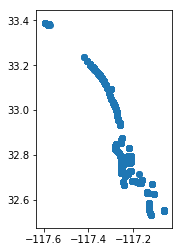

In [11]:
from shapely.geometry import Point
import geopandas as gpd


## Create a new GeoPandas frame, converting the targetlongitude and targetlatitude
## colums to a Shapely Point and assigning it to the frame's geometry

gdf = gpd.GeoDataFrame(df, geometry=
                        [Point(x,y) for x,y in zip(df.targetlongitude, df.targetlatitude)])

# Here is a quick plot
gdf.plot()

## Add a County Outline

The quick graph doesn't have any context for the rest of the county, so let's get another Metatab package with geographic information for the outline of San Diego county. 

In [12]:

## Load a Metapack data package of the US Counties, then extract San Diego county by it's FIPS code, state=6
## county=73 
counties_pkg = mp.open_package('http://library.metatab.org/census.gov-counties-2017-2.csv')

# Use the Metapack feature for turning the Pandas dataframe into a GeoPandas dataframe
counties = counties_pkg.resource('counties').geoframe()

sd_county = counties[(counties.statefp==6) & (counties.countyfp==73) ]

It will be important to verify that the groups of stations are actually geographically close, which is easy to check by coloring each of the groups. The Geopandas ``.plot()`` method has a ``column`` parameter which specifies the colum used to differentiate point colors. 

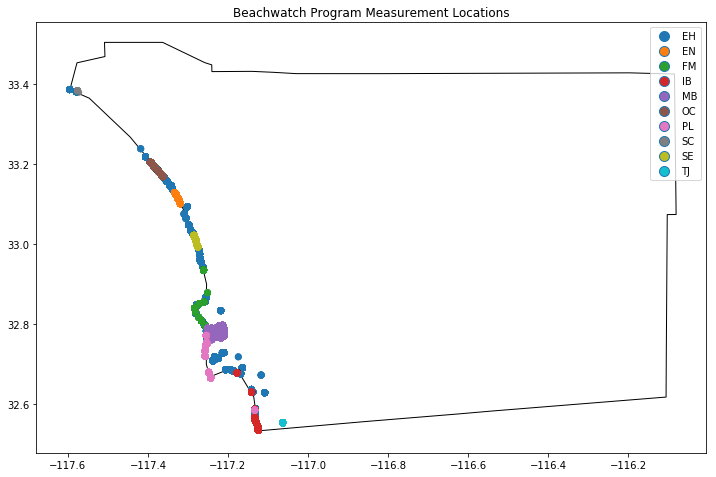

In [13]:
## Plot the county, then use the same Matplotlib axis to plot the points. 
base = sd_county.plot(color='white', edgecolor='black', figsize=(8*1.5,8))
gdf.plot(ax=base,  column='stationgroup', legend=True)
plt.title("Beachwatch Program Measurement Locations")
plt.show()

The 'EH' group seems really spread out, so let's have a closer look at just that group. 


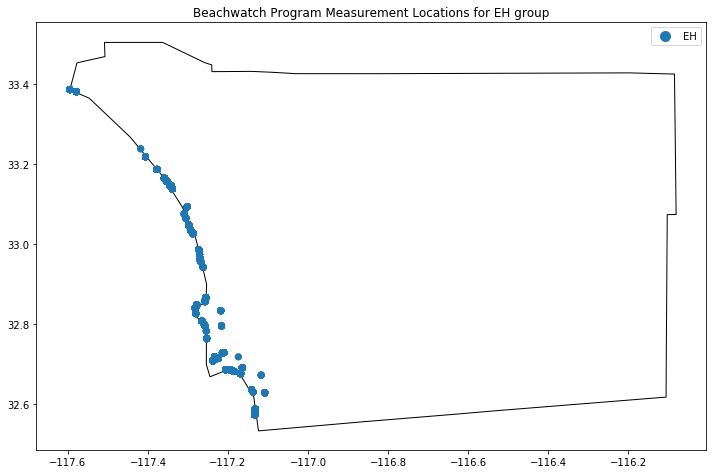

In [14]:
## Plot the county, then use the same Matplotlib axis to plot the points. 
base = sd_county.plot(color='white', edgecolor='black', figsize=(8*1.5,8))
gdf[(gdf.stationgroup == 'EH') ].plot(ax=base,  column='stationgroup', legend=True)
plt.title("Beachwatch Program Measurement Locations for EH group")
plt.show()

The 'EH' group is all over the coast, so the stations in that group probably wont correlate with each other very well, and there are a small number of records for each of the EH stations.  Let's exclude it. 


In [15]:
df = df[df.stationgroup != 'EH']


In [16]:
# Write the station positions so we can load them into a map. 
df[['stationgroup','stationcode','stationname','targetlongitude','targetlatitude']].drop_duplicates().to_csv('stations.csv')

There is a [higher detail map of stations in PDF format in the shread Google Drive](https://drive.google.com/file/d/1_QVzn1wylIjlQQgn3DO7fDX_qCUYc7jy/view?usp=sharing), also this image below. BOth the PDF and the image below were created by exporting the positions of stations in CSV and loading them into QGIS. 


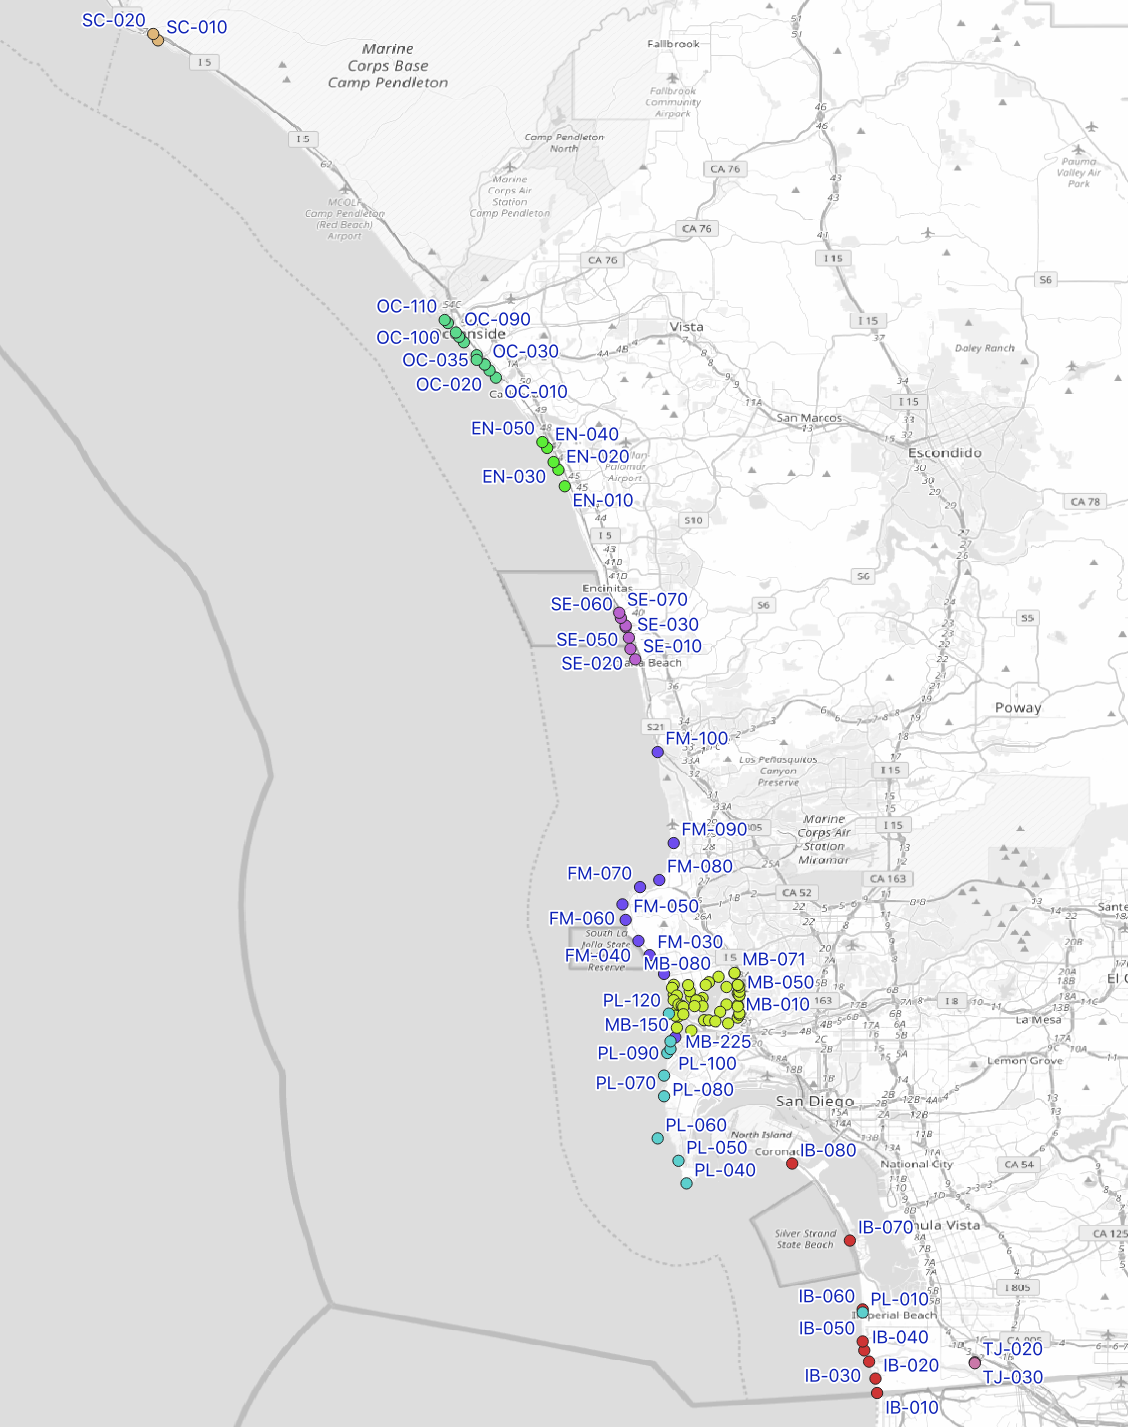

In [17]:

from IPython.display import Image
Image(filename='beachwatchmap.png') 

# Log or Not?

The first of these two plots is bacteria count with the raw ``results`` column. The second uses the log transformed results from ``log_results``


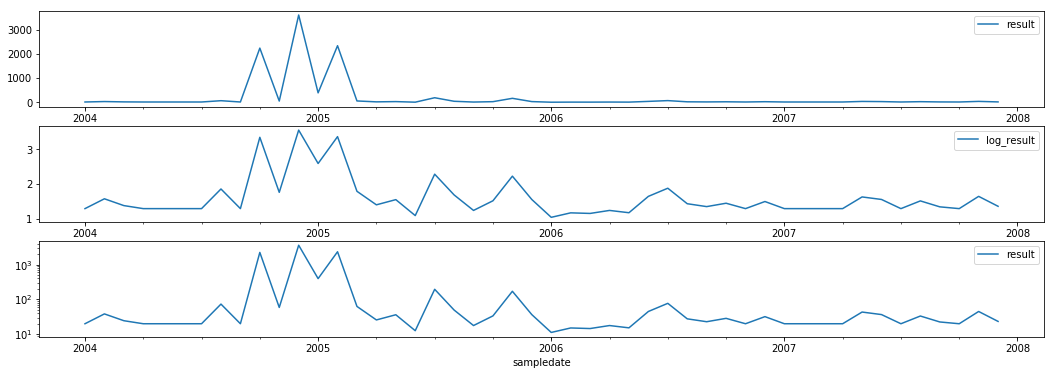

In [18]:
# The results has a large range, so log transformation makes them easier to visualize. These three plots show the original 
# result column, the column plotted with a log scale, and the column plotted with the data log transformed. 
# The really important part here is that the log trasform must be run after the resampling, because adding  values gets a 
# very different result from adding their logs

fig, ax = plt.subplots(3,figsize=(18,6))

_ = df[(df.stationcode=='IB-080') & (df.sampledate.dt.year > 2003) & (df.sampledate.dt.year < 2008)].set_index('sampledate').resample('1m').mean()

# Log transformation myst be applied after resampling. l
_['log_result'] = _.result.apply(np.log10)

_.plot(ax=ax[0], y='result')

ax[2].set_yscale("log", basey=10)
_.plot(ax=ax[2], y='result')

_.plot(ax=ax[1], y='log_result')

# Station group correlations

It is likely that since stations within a group are close to each other, the measures for one group are similar to others in the same group. So, we should try to characterize how well readings between stations in a group are correlated. 

The first way to examine correlations is usually to examine plots, so well create multiple plots, one for each station group to see if it looks like the results vary together.  


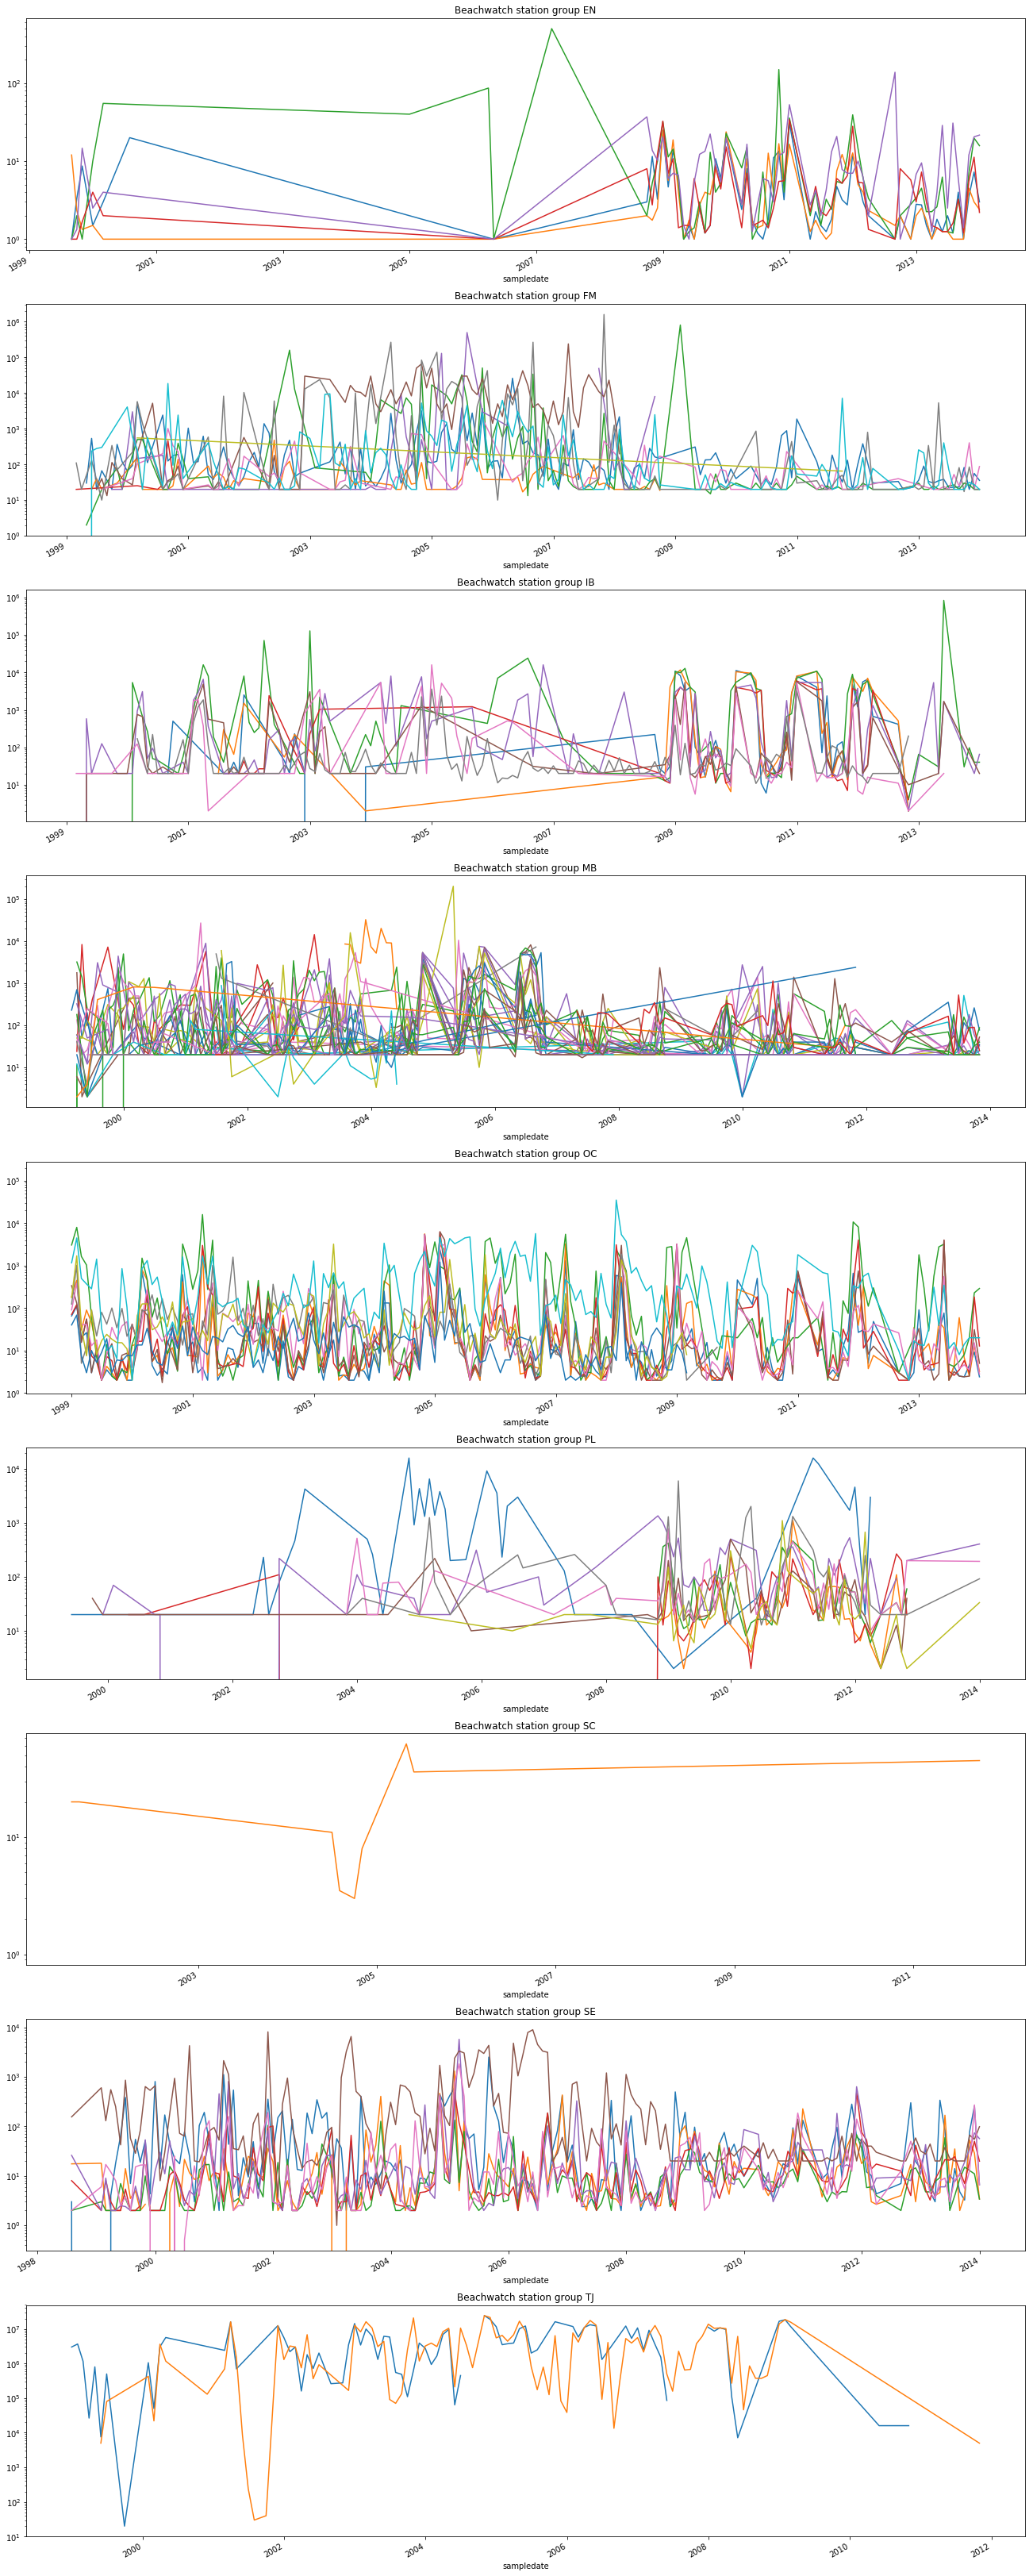

In [19]:
groups = list(df.stationgroup.unique())
fig, axes = plt.subplots(len(groups), 1,figsize=(18,5*len(groups)))

for ax, group in zip(axes, groups):
    
    _ = df[(df.stationgroup==group)]\
        .set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='m')]).mean()
    _['log_result'] = _.result.apply(np.log10)
    _.reset_index().set_index('sampledate').groupby('stationcode').plot(ax=ax,y='result', legend = False)
    ax.set_yscale("log", nonposy='clip')
    ax.set_title("Beachwatch station group {}".format(group))

    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    


## Mean Group Correlations and Pairwise Station Correlations 

In many cases, it looks stations within a group are correlated, although some look like they have less correlation than others. Next, we can try to do quantify the corelation. The Pandas ``.corr()``  method compute correlations for each pair of columns, returning a matrix. For a first attempt, we'll just take the mean of the pairwise correlations. 

In [20]:
from IPython.display import display

def mean_correlation(df, group, column='result'):
    """Build the corelation matrix for all columns, remove the diagonal, and average the remaining values. This uses
    the full matrix, not the triangular matrix, so each value appears twice. """
    
    _ = df[(df.stationgroup==group)]\
            .set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='m')]).mean()
    _['log_result'] = _.result.apply(np.log10)
    _ = _.reset_index().set_index(['stationcode','sampledate'])[column].unstack(level=0)
    corr = _.corr().stack().to_frame()
    corr.columns = [column]
    
    _ = corr[corr[column] < 1.0]

    
    return _.mean().iloc[0]


Should we try to correlate the results, or the log results? Let's try both.

In [21]:
pd.DataFrame([ (group, mean_correlation(df, group,'result') ) for group in groups ]).sort_values(1, ascending=False)
    

0         1
8  TJ  0.756425
2  IB  0.483982
0  EN  0.407427
4  OC  0.319334
7  SE  0.246714
5  PL  0.176240
3  MB  0.061253
1  FM  0.016416
6  SC       NaN

In [22]:
pd.DataFrame([ (group, mean_correlation(df, group,'log_result') ) for group in groups ]).sort_values(1, ascending=False)
   

0         1
8  TJ  0.655636
0  EN  0.539134
2  IB  0.504232
4  OC  0.452197
7  SE  0.326301
5  PL  0.242845
3  MB  0.140501
1  FM  0.123852
6  SC       NaN

I don' know that it's technical better, but the log results corelation are more like what we'd expect, with strong connections for EN and IB. TJ and SC have few readings on few datasets, so they should be ignored,  but the correlations on the others are stronger for the log results. 


In [23]:
def station_corr_matrix(df, group):
    _ = df[(df.stationgroup==group)].set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='m')]).mean()[['result']]
    _.reset_index().set_index(['stationcode','sampledate'])['result']
    _['result'] = _.result.apply(np.log10)
    return _.unstack(level=0).corr()

def plot_stations_annotated(gdf, group, figsize=None):

    _ = gdf[gdf.stationgroup==group]

    if figsize:
        fig, ax = plt.subplots(1,figsize=figsize)
        _.plot(ax=ax)
    else:
        ax = _.plot()

    for x, y, label in zip(_.geometry.x, _.geometry.y, _.stationcode):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

result                                        
stationcode           EN-010    EN-020    EN-030    EN-040    EN-050
       stationcode                                                  
result EN-010       1.000000  0.708135  0.670475  0.692055  0.418737
       EN-020       0.708135  1.000000  0.574485  0.592271  0.327111
       EN-030       0.670475  0.574485  1.000000  0.628896  0.392701
       EN-040       0.692055  0.592271  0.628896  1.000000  0.386477
       EN-050       0.418737  0.327111  0.392701  0.386477  1.000000

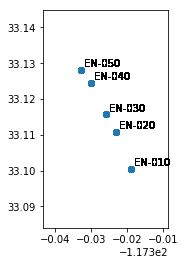

In [24]:
display(station_corr_matrix(df, 'EN'))
plot_stations_annotated(gdf, 'EN')

This is odd; There is a high correlation between ``EN-050`` and ``EN-040``, which is expected because they are next to each other, but ``EN-020`` has a slight negative correlation t0 ``EN-030``, which it is adacent to, but a positive correlation to ``EN-040`` which is farther away. 

result                                          \
stationcode           IB-010    IB-020    IB-030    IB-040    IB-050   
       stationcode                                                     
result IB-010       1.000000  0.908323  0.713853  0.619416  0.632462   
       IB-020       0.908323  1.000000  0.668886  0.660695  0.668446   
       IB-030       0.713853  0.668886  1.000000  0.673543  0.630493   
       IB-040       0.619416  0.660695  0.673543  1.000000  0.916039   
       IB-050       0.632462  0.668446  0.630493  0.916039  1.000000   
       IB-060       0.483203  0.560551  0.572791  0.707664  0.740594   
       IB-070       0.340613  0.394001  0.204478  0.425452  0.463144   
       IB-080       0.068110 -0.048785  0.015335  0.115044  0.297340   

                                                  
stationcode           IB-060    IB-070    IB-080  
       stationcode                                
result IB-010       0.483203  0.340613  0.068110  
       IB-020       0.560551  0.394001 -0.048785  
       IB-030       0.572791  0.204478  0.015335  
       IB-040       0.707664  0.425452  0.115044  
       IB-050       0.740594  0.463144  0.297340  
       IB-060       1.000000  0.635393  0.483520  
       IB-070       0.635393  1.000000  0.567900  
       IB-080       0.483520  0.567900  1.000000

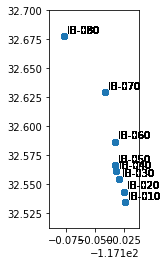

In [25]:
display(station_corr_matrix(df, 'IB'))
plot_stations_annotated(gdf, 'IB')

The IB correlations look more sensible. ``IB-070`` and ``IB-080`` have a strong correlation with each other, but not the rest, since they are farther away. The more southern stations are strongly correlated with each other. 

result                                                 \
stationcode           MB-010 MB-015    MB-020    MB-030    MB-031    MB-040   
       stationcode                                                            
result MB-010       1.000000    NaN -0.561518  0.004018  0.767503  0.695308   
       MB-015            NaN    NaN       NaN       NaN       NaN       NaN   
       MB-020      -0.561518    NaN  1.000000  0.228268 -1.000000 -0.209517   
       MB-030       0.004018    NaN  0.228268  1.000000  0.504232 -0.223738   
       MB-031       0.767503    NaN -1.000000  0.504232  1.000000  0.882730   

                                                             ...               \
stationcode          MB-041    MB-042    MB-050    MB-051    ...       MB-180   
       stationcode                                           ...                
result MB-010           NaN  1.000000  0.547545       NaN    ...     0.491376   
       MB-015           NaN       NaN       NaN       NaN    ...          NaN   
       MB-020           NaN       NaN  0.126848       NaN    ...    -0.572253   
       MB-030       1.00000 -0.280823  0.125154 -0.959313    ...     0.343409   
       MB-031       0.45685  0.772627  0.719230  0.318134    ...          NaN   

                                                                      \
stationcode           MB-190    MB-191    MB-192    MB-193    MB-200   
       stationcode                                                     
result MB-010       0.031599       NaN       NaN       NaN -1.000000   
       MB-015            NaN       NaN       NaN       NaN       NaN   
       MB-020      -1.000000       NaN       NaN       NaN       NaN   
       MB-030      -0.331696 -0.270650 -0.642381       NaN  0.813305   
       MB-031            NaN  0.176063  0.258657  0.643172  1.000000   

                                                            
stationcode           MB-203    MB-205    MB-223    MB-225  
       stationcode                                          
result MB-010       0.606820  0.371025  0.310419  0.753258  
       MB-015            NaN       NaN       NaN       NaN  
       MB-020            NaN       NaN       NaN       NaN  
       MB-030            NaN       NaN  0.061087 -0.364385  
       MB-031       0.429436 -0.282045  0.555228  0.585567  

[5 rows x 46 columns]

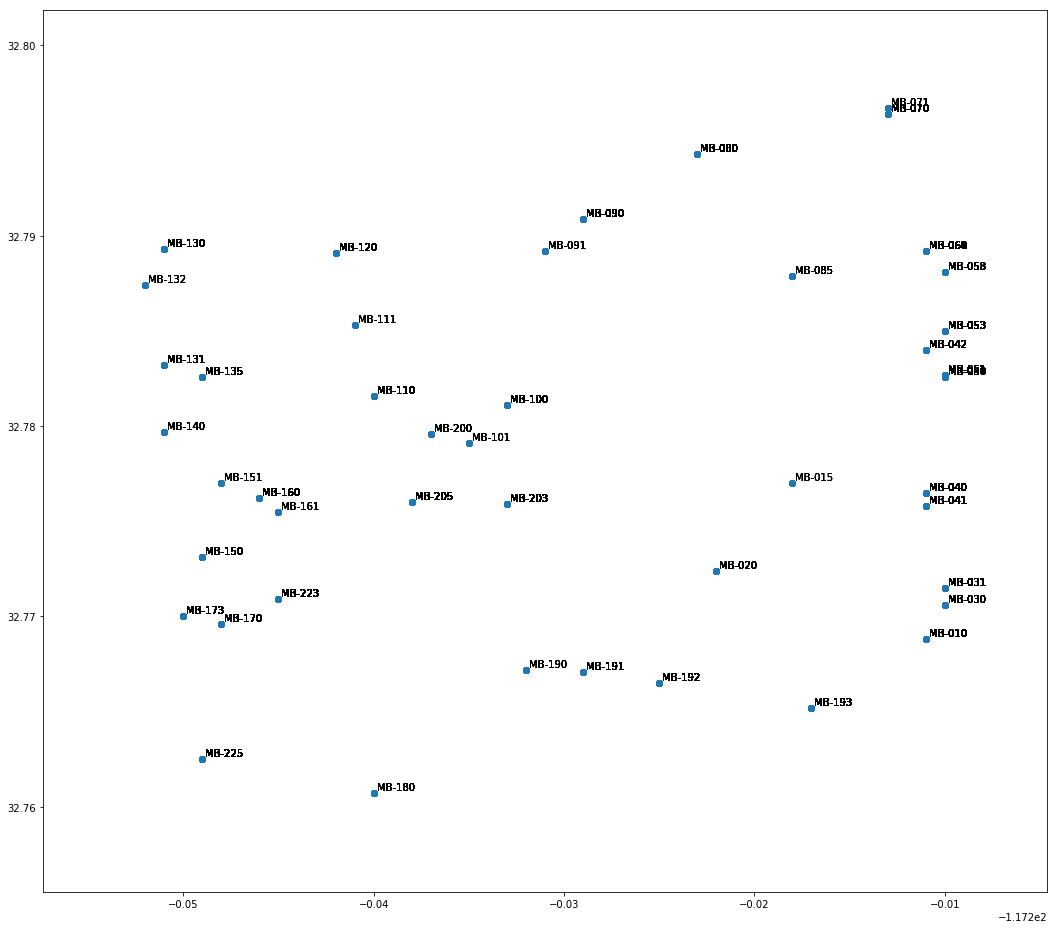

In [26]:
display(station_corr_matrix(df, 'MB').head())
plot_stations_annotated(gdf, 'MB', figsize=(18,18))

# More Correlations


Let's look at correlatios across all of the stations, using a different method. Here we will create a coorelation matrix of all stations, then remove all of the duplicates, using a sorting method, rather than the traditional method of using a triangular mask. Then we can plot the most correlated station pairs to see if they look right. 

In [28]:
# Pull out the MB stations because, while there are a lot of MB group readings, there 
# is a small number of them for each station
_ = df[~df.stationgroup.isin(['MB','SC'])][['stationcode','sampledate','result']]\
        .set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='d')]).max()
_ = _.unstack(0)
_.columns  = _.columns.get_level_values(1)
bw_uns = _
bw_uns.head()

stationcode  EN-010  EN-020  EN-030  EN-040  EN-050  FM-010  FM-020  FM-030  \
sampledate                                                                    
1999-08-30      1.0    12.0     1.0     1.0     1.0     NaN     NaN     NaN   
1999-09-07      4.0     4.0     1.0     1.0     1.0     NaN     NaN     NaN   
1999-09-13      1.0     1.0     1.0     1.0     2.0     NaN     NaN     NaN   
1999-09-27      5.0     2.0     4.0     1.0     1.0     NaN     NaN     NaN   
1999-10-04      1.0     2.0     1.0     NaN     NaN     NaN     NaN     NaN   

stationcode  FM-040  FM-050   ...    PL-120  SE-010  SE-020  SE-030  SE-040  \
sampledate                    ...                                             
1999-08-30      NaN     NaN   ...       NaN     NaN     NaN     NaN     NaN   
1999-09-07      NaN     NaN   ...       NaN     NaN     NaN     NaN     NaN   
1999-09-13      NaN     NaN   ...       NaN     NaN     NaN     NaN     NaN   
1999-09-27      NaN     NaN   ...       NaN    11.0     2.0     2.0     4.0   
1999-10-04      NaN     NaN   ...       NaN     NaN     NaN     NaN     NaN   

stationcode  SE-050  SE-060  SE-070  TJ-020  TJ-030  
sampledate                                           
1999-08-30      NaN     NaN     NaN     NaN     NaN  
1999-09-07      NaN     NaN     NaN    20.0     NaN  
1999-09-13      NaN     NaN     NaN     NaN     NaN  
1999-09-27      2.0     7.0    30.0     NaN     NaN  
1999-10-04      NaN     NaN     NaN     NaN     NaN  

[5 rows x 52 columns]

In [29]:
bw_uns_l = np.log(bw_uns)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [36]:
def build_corr_ranks(df):
    _ = df.corr().stack().sort_values(ascending=False).to_frame()
    _.columns = ['result']
    _ = _[_.result< .99999]
    _.index.set_names(['sc1', 'sc2'], inplace=True)
    _.reset_index(inplace=True)

    # The correlation function is symmetric, so the dataframe has correlation values for (a,b) 
    # and for (b,a). We git rid of these by sording the station codes, then removing duplicates. 
    cond = _.sc1 > _.sc2
    _.loc[cond, ['sc1', 'sc2']] = _.loc[cond, ['sc2', 'sc1']].values
    _ = _.drop_duplicates()

    _ = _.copy()

    _['sg1'] = _.sc1.str[:2]
    _['sg2'] = _.sc2.str[:2]

    return _
    
corr_ranks = build_corr_ranks(bw_uns_l)
corr_ranks.head()

sc1     sc2    result sg1 sg2
0  FM-070  OC-022  0.997023  FM  OC
2  IB-060  PL-010  0.990909  IB  PL
4  OC-100  TJ-030  0.961686  OC  TJ
6  EN-010  OC-090  0.960165  EN  OC
8  IB-080  PL-010  0.921077  IB  PL

Here are the plots. Notice that in a lot of cases, there is a high corelation, but only on a small part of the range, because one station has a lot fewer measurements than the other. 

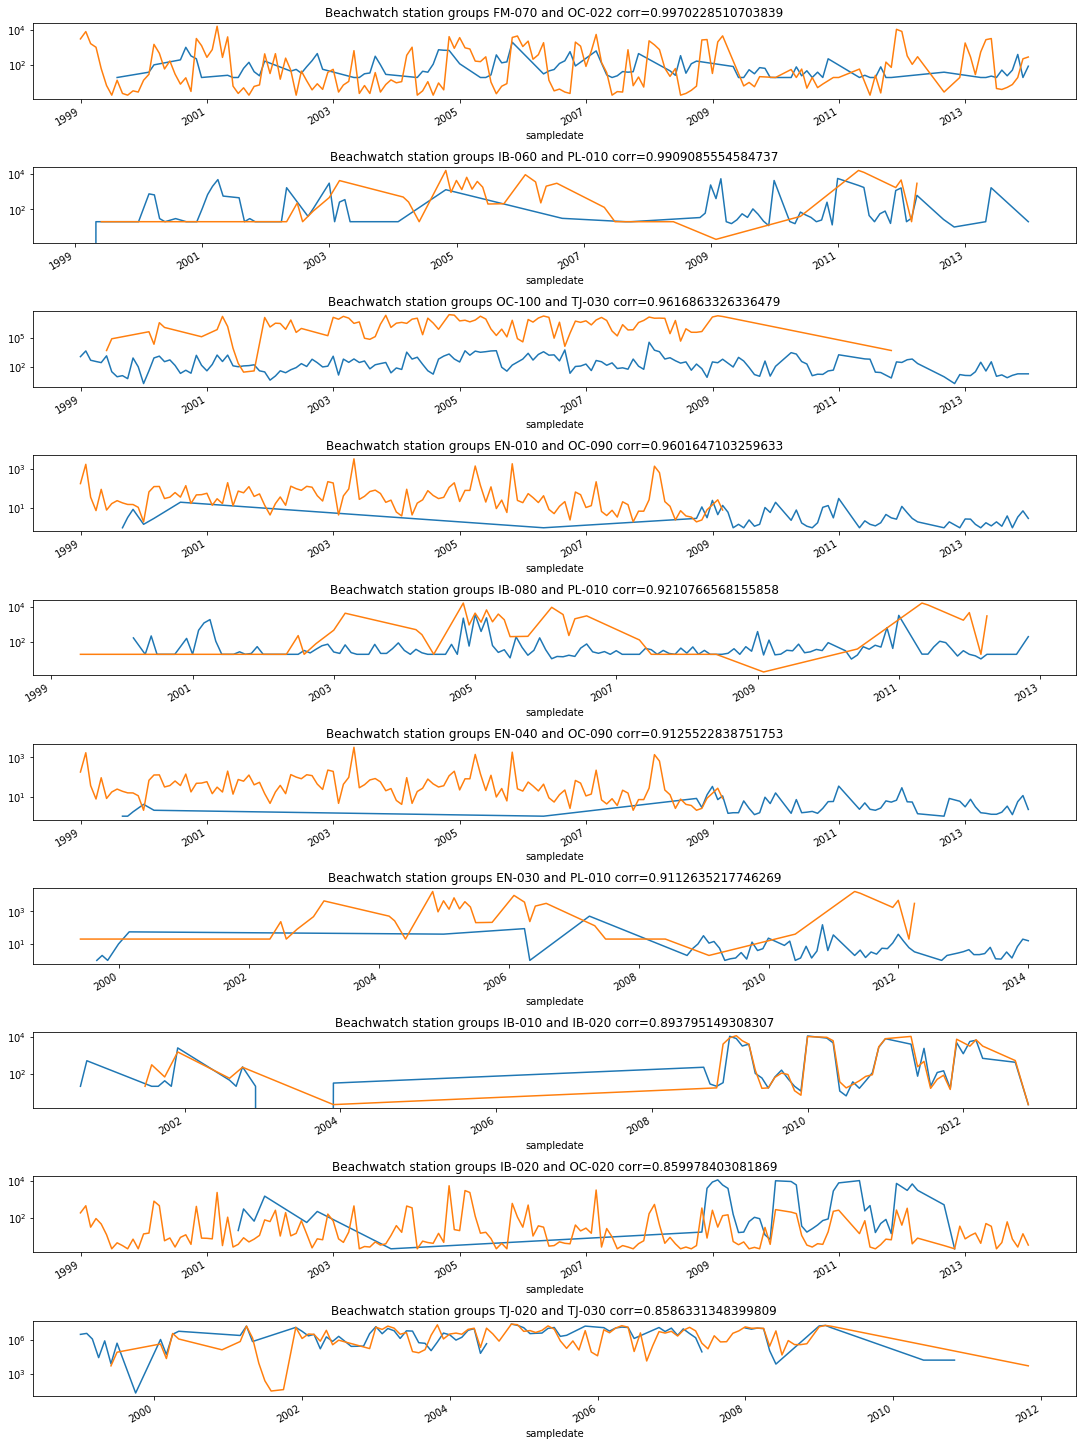

In [42]:
def plot_corr_pairs(df, corr):
    
    fig, axes = plt.subplots(len(corr),figsize=(15,2*len(corr)))

    for ax, (idx, r) in zip(axes,corr.iterrows()):

        _ = df[df.stationcode.isin([r.sc1,r.sc2])]\
               .set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='m')]).mean()
        _['log_result'] = _.result.apply(np.log10)
        _.reset_index().set_index('sampledate').groupby('stationcode').plot(ax=ax,y='result', legend = False)
        ax.set_yscale("log", nonposy='clip')
        ax.set_title("Beachwatch station groups {} and {} corr={}".format(r.sc1, r.sc2, r.result))


    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    

plot_corr_pairs(df, corr_ranks.iloc[:10])

Look for correlations specifically among stations from different station groups. Most of these look spurious, but the correlations bewtween the IB and OC stations after 2009 look strong, which is very suspicious because they are the most distant two station groups. 

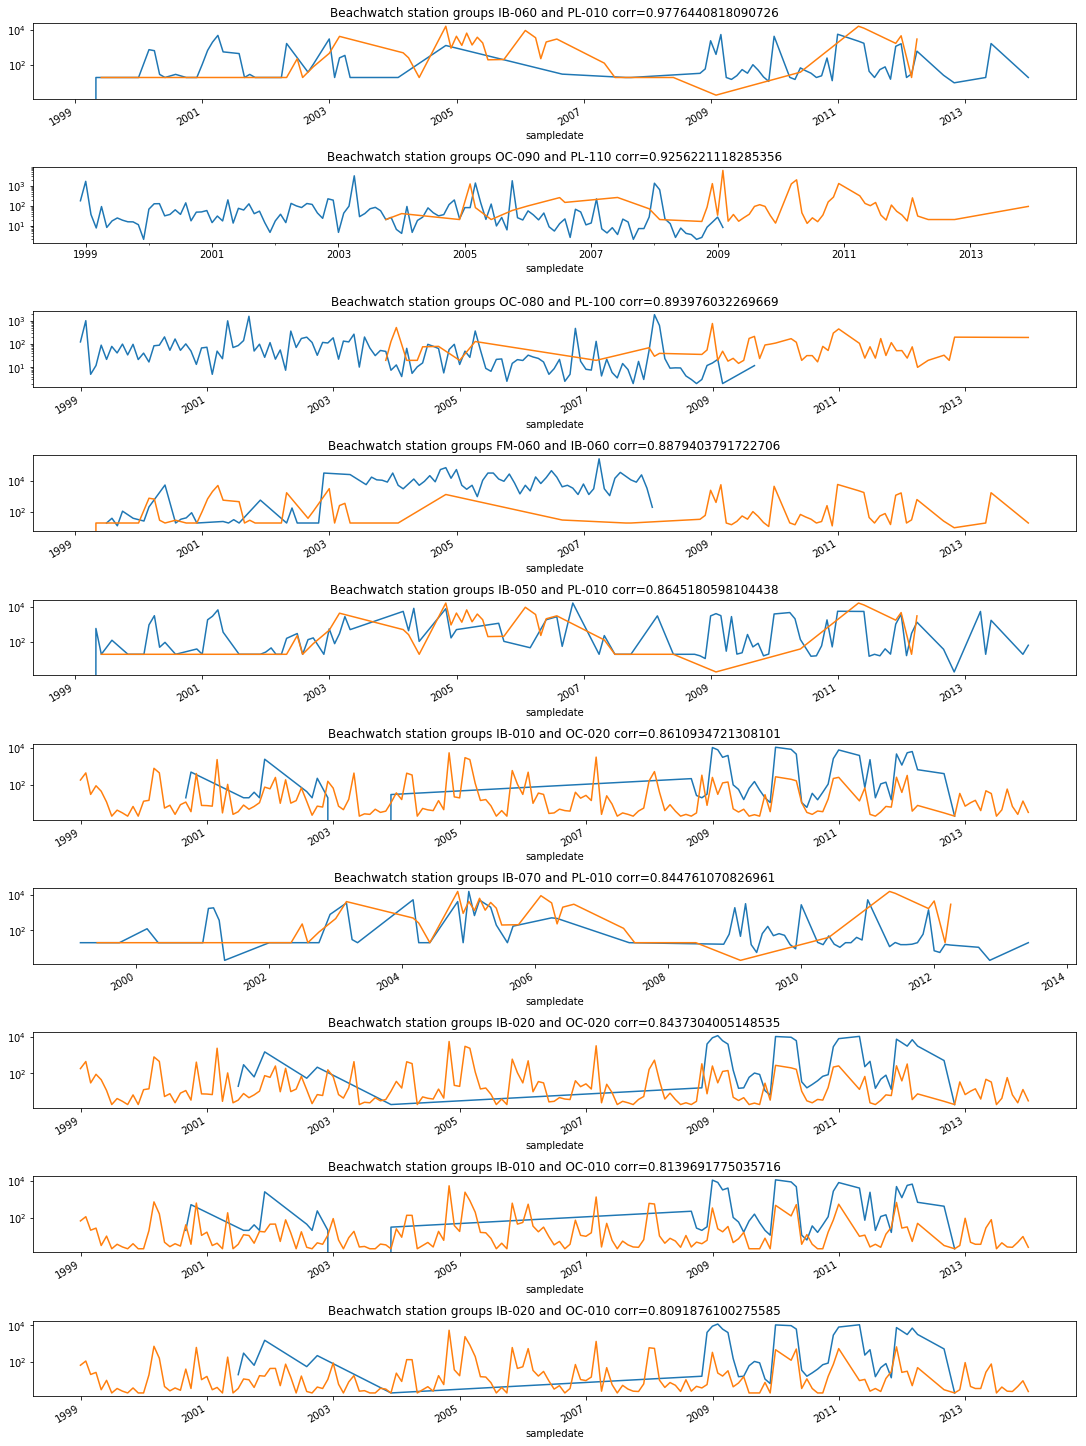

In [32]:
plot_corr_pairs(df, corr_ranks[corr_ranks.sg1 != corr_ranks.sg2 ].iloc[:10])

### Why are OC and IB Correlated?

The IB and OC stations, which are the farthest appart,  seem oddly correalted, after 2009. Below are plots of the top correlated stations. I suspect these are correlated because they are the stations that have the strongest seasonal variation; they are not actually correlated to each other, but are rather both correlated to the seasons. 

From that perspective, the interesting question is not why are these station groups correlated with each other, but why aren't all of the station groups correlated. 



In [52]:
corr_ranks_2009 = build_corr_ranks(bw_uns_l.loc['2009':])
ib_oc_09_cr = corr_ranks_2009[ (corr_ranks_2009.sg1.isin(['IB','OC'])) &  \
                               (corr_ranks_2009.sg2.isin(['IB','OC'])) &  \
                               (corr_ranks_2009.sg1 != corr_ranks_2009.sg2) ]
ib_oc_09_cr.iloc[:10]

sc1     sc2    result sg1 sg2
16   IB-020  OC-020  0.859978  IB  OC
20   IB-010  OC-020  0.857085  IB  OC
30   IB-020  OC-010  0.809331  IB  OC
32   IB-010  OC-010  0.800330  IB  OC
40   IB-020  OC-030  0.748849  IB  OC
44   IB-010  OC-030  0.746946  IB  OC
70   IB-030  OC-020  0.670576  IB  OC
82   IB-010  OC-040  0.655152  IB  OC
106  IB-020  OC-040  0.606516  IB  OC
110  IB-030  OC-010  0.602476  IB  OC

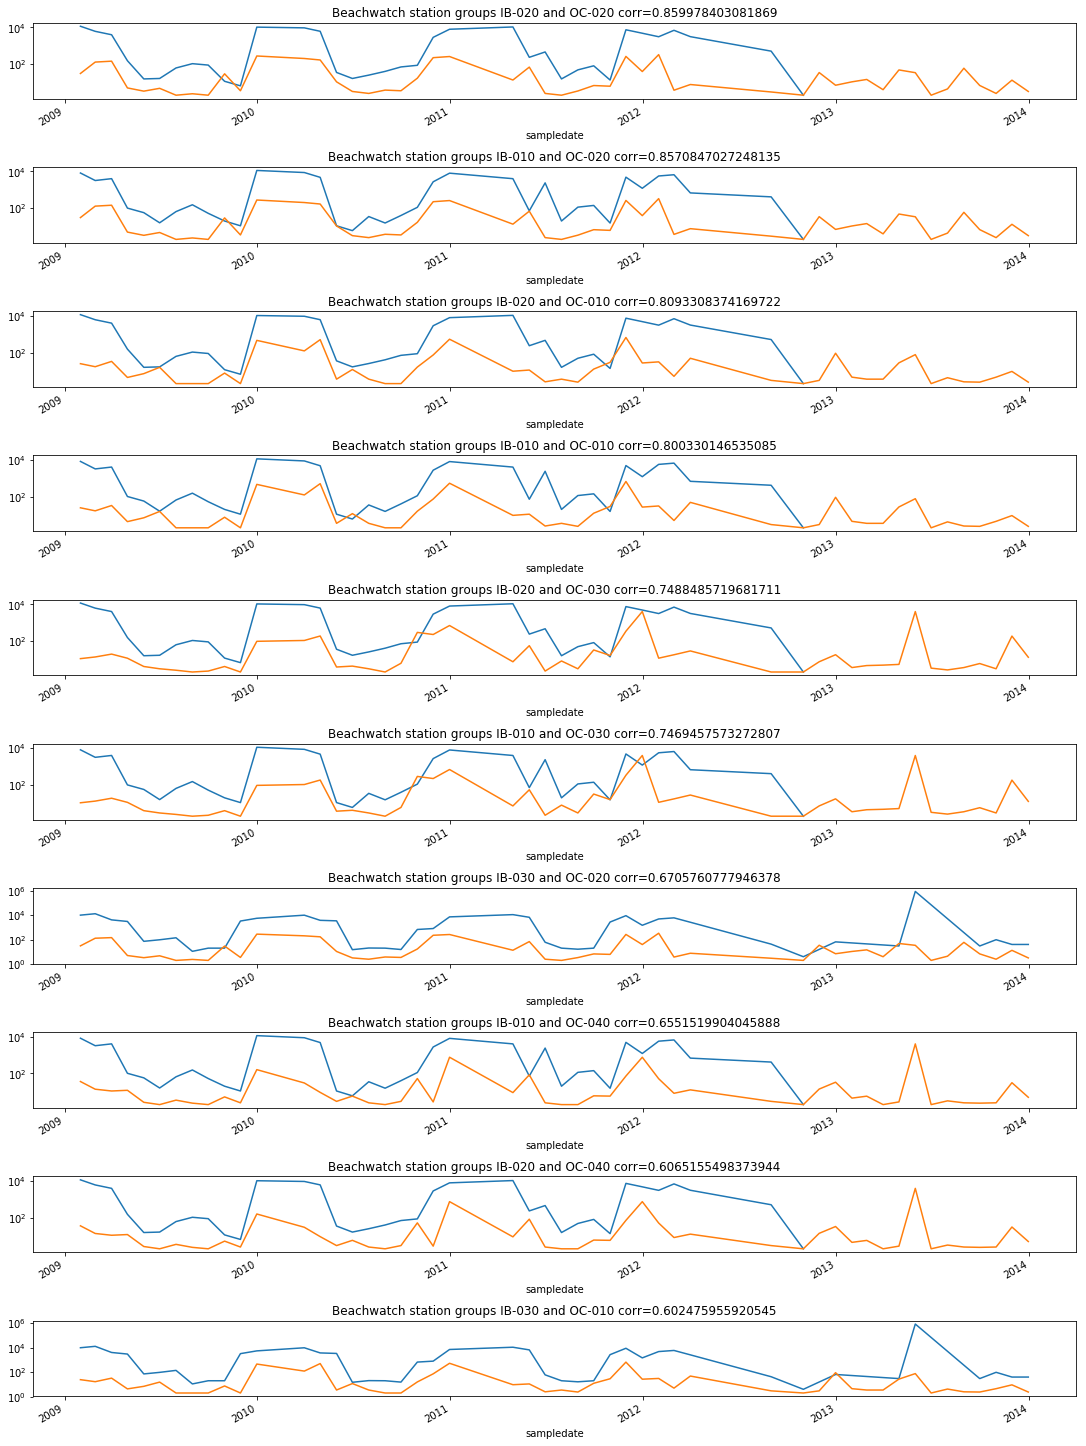

In [53]:
plot_corr_pairs(df[df.sampledate.dt.year >=2009], ib_oc_09_cr.iloc[:10])

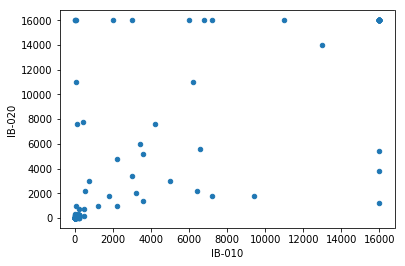

In [33]:
bw_uns[['IB-010','IB-020']].dropna().plot(kind='scatter', x='IB-010',y='IB-020')

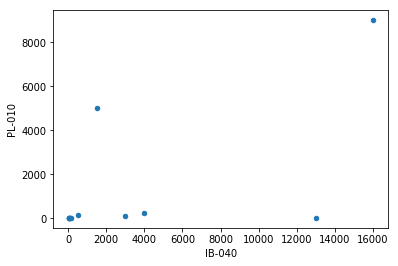

In [34]:
bw_uns[['IB-040','PL-010']].dropna().plot(kind='scatter', x='IB-040',y='PL-010')

# Next Steps

This analysis provides some guidance for future analysis. Conclusions include: 

- We should probably analyze log results, rather than just results. 
- Stations that are close to each other are likely to have correlated results. We might be able to create composite measurements from groups of stations. 

Questions we should answer with addtional analysis: 

- What watersheds are the station groups in? Are all stations in one group in the same watershed?
- What creeks are the stations near?
- How do results correlate to rainfall?
- How do results correlate to creek flow. 